#### Importing packages

In [101]:
# Load packages 

import collections
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pprint
import pymongo

import seaborn as sns
import uuid

from bson.objectid import ObjectId
from collections import Counter
from datetime import datetime
from dateutil import parser


## Overview

1. <strong>Load annotations for a task </strong>


2. <strong>Calculate stats related to this task, e.g. number of workers, time for annotation, etc. </strong>


3. <strong>Apply majority voting and update database </strong> 

Set the following variables first:


In [102]:
# Set the task to be postprocessed: "table_relevance", "claim_adjustment", "verification"
task = "claim_explanation_verification"

# Load file with annotations into pandas.DataFrame OR if annotations saved in DB, create client and load data, example below 
df = pd.DataFrame()

PROJECT_PATH = r"/Users/user/Library/CloudStorage/OneDrive-King'sCollegeLondon/PycharmProjects/chartfc_dataset_wikicommons"
PATH_MONGODB_CREDENTIALS = os.path.join(PROJECT_PATH, 'config/mongodb_credentials.json')
# PATH_BANNED_WORKERS = os.path.join(PROJECT_PATH, 'config/banlist.json')

# PATH_BANNED_WORKERS = os.path.join(PROJECT_PATH, 'config/banlist_claim_explanation_generation.json')
PATH_BANNED_WORKERS = os.path.join(PROJECT_PATH, 'config/banlist_claim_explanation_verification.json')



--------

In [104]:
# Load annotation data from MongoDB 

with open(PATH_MONGODB_CREDENTIALS,'r') as f:
    mongodb_credentials = json.load(f)

# db_client = pymongo.MongoClient(mongodb_credentials["connection_string"])
# db = db_client['chartfc']

# hit_result_collection = db.hit_results
hit_result_collection = db.hit_results_claim_explanation_verification

cursor = hit_result_collection.find({})
df = pd.DataFrame(list(cursor))

print(f"Number of samples in 'hit_result_collection' is {len(df)}")


Number of samples in 'hit_result_collection' is 690


### Create dataframe

In [127]:
# load list of banned workers to exclude them
with open(PATH_BANNED_WORKERS,'r') as f:
    banlist = json.load(f)

# load list of rejected assignments to exclude them (if any exist)
# rejected_assignments = pd.read_excel("filled_answer_df.xlsx")
# rejected_assignments = list(rejected_assignments[rejected_assignments["reject"]==1].assignment_id)

print(f"Number of banned workers is {len(banlist)}.")
# print(f"Number of rejected assignments is {len(rejected_assignments)}.")


Number of banned workers is 12.


In [128]:
cols = list(df.columns)
#cols.remove("language")
cols.remove("type")
cols.remove("timestamp")
cols.remove("answers")
cols.extend(['worker_id', 'outputs', 'times', 'events', 'feedback'])

annotations_df = pd.DataFrame(columns = cols)
counter_skip = 0
index = 0
for i, row in df.iterrows(): 
#     if task != "claim_generation" and (type(row["answers"])!=list or len(row["answers"]) < 3): # we only consider df entries with completed assignments 3/3
#         counter_skip += 1
#         continue 

#     if type(row["answers"])!=list or len(row["answers"]) == 0: # we only consider df entries with completed assignments 3/3
#         counter_skip += 1
#         continue 
    
    for worker_answer in row["answers"]:
        #if worker_answer["worker_id"] in banlist or worker_answer["assignment_id"] in rejected_assignments:
        #    print("Skipped because worker is banned or assignment has been rejected.")
        #    counter_skip += 1
        #    continue
        
        row["worker_id"] = worker_answer["worker_id"]
        annotations_df.at[index, "_id"] = row["_id"]
        annotations_df.at[index, "batch_id"] = row["batch_id"]
        annotations_df.at[index, "references"] = row["references"]
        annotations_df.at[index, "taskSet_id"] = row["taskSet_id"]
        annotations_df.at[index, "hit"] = row["hit"]
        
        annotations_df.at[index, "worker_id"] = worker_answer["worker_id"]
        annotations_df.at[index, "assignment_id"] = worker_answer["assignment_id"]
        annotations_df.at[index, "outputs"] = worker_answer["values"]["outputs"]
        annotations_df.at[index, "times"] = worker_answer["values"]["times"]
        annotations_df.at[index, "events"] = worker_answer["values"]["events"]
        annotations_df.at[index, "feedback"] = worker_answer["values"]["feedback"]
        index += 1

print(len(annotations_df))
counter_skip


ValueError: list.remove(x): x not in list

In [129]:
# | worker | claim id | label |

if task in ["chart_filtering"]:
    output_df = pd.DataFrame(columns=["HIT_id", "batch_id", "taskSet_id", "worker_id", "chart_id", "chart_img", "caption",
                                      "label", "header", "events"])

    index = 0
    for i, row in annotations_df.iterrows():
        for j in range(len(row["references"])):
            if row["references"][j]["g_id"]!=-1:
                continue

            output_df.at[index, "HIT_id"] = row["_id"]
            output_df.at[index, "batch_id"] = row["batch_id"]
            output_df.at[index, "taskSet_id"] = row["taskSet_id"]
            output_df.at[index, "worker_id"] = row["worker_id"]

            output_df.at[index, "chart_id"] = row["references"][j]["db_id"]
            output_df.at[index, "chart_img"] = row["references"][j]["chart_img"]
            output_df.at[index, "caption"] = row["references"][j]["caption"]

            output_df.at[index, "label"] = row["outputs"][j]["label"]
            output_df.at[index, "header"] = row["outputs"][j]["header"]
            output_df.at[index, "events"] = row["events"][j]
            index += 1

    print(len(output_df))
    
elif task == "claim_explanation_generation": 
    
    output_df = pd.DataFrame(columns=["HIT_id", "batch_id", "taskSet_id", "worker_id", "chart_id", "chart_img", "caption",
                                      "claim_text_support", "explanation_claim_text_support", "claim_text_refute",
                                      "explanation_claim_text_refute", "events"])
    index = 0
    for i, row in annotations_df.iterrows():
        for j in range(len(row["references"])):
            try:
                output_df.at[index, "HIT_id"] = row["_id"]
                output_df.at[index, "batch_id"] = row["batch_id"]
                output_df.at[index, "taskSet_id"] = row["taskSet_id"]
                output_df.at[index, "worker_id"] = row["worker_id"]

                output_df.at[index, "chart_id"] = row["references"][j]["db_id"]
                output_df.at[index, "chart_img"] = row["references"][j]["chart_img"]
                output_df.at[index, "caption"] = row["references"][j]["caption"]

                output_df.at[index, "claim_text_support"] = row["outputs"][j]["claim_text_support"]
                output_df.at[index, "explanation_claim_text_support"] = row["outputs"][j]["explanation_claim_text_support"]
                output_df.at[index, "claim_text_refute"] = row["outputs"][j]["claim_text_refute"]
                output_df.at[index, "explanation_claim_text_refute"] = row["outputs"][j]["explanation_claim_text_refute"]

                output_df.at[index, "events"] = row["events"][j]

                index += 1  
            except Exception: 
                print(f"Error for index {i}")
                continue 

    print(f"Length of dataset: {len(output_df)}")
    print(f"Number of claims: {len(output_df)*2}")
    
elif task == "claim_explanation_verification": 
    output_df = pd.DataFrame(columns=["HIT_id", "batch_id", "taskSet_id", "worker_id", "chart_id", "chart_img", "caption",
                                  "claim_rewritten", "explanation_rewritten", "label_claim", "label_explanation", "events"])
    index = 0
    for i, row in annotations_df.iterrows():
        for j in range(len(row["references"])):
            try:
                output_df.at[index, "HIT_id"] = row["_id"]
                output_df.at[index, "batch_id"] = row["batch_id"]
                output_df.at[index, "taskSet_id"] = row["taskSet_id"]
                output_df.at[index, "worker_id"] = row["worker_id"]

                output_df.at[index, "chart_id"] = row["references"][j]["db_id"]
                output_df.at[index, "chart_img"] = row["references"][j]["chart_img"]
                output_df.at[index, "caption"] = row["references"][j]["caption"]

                output_df.at[index, "claim_rewritten"] = row["outputs"][j]["claim_rewritten"]
                output_df.at[index, "explanation_rewritten"] = row["outputs"][j]["explanation_rewritten"]
                output_df.at[index, "label_claim"] = row["outputs"][j]["label_claim"]
                output_df.at[index, "label_explanation"] = row["outputs"][j]["label_explanation"]


                output_df.at[index, "events"] = row["events"][j]
                index += 1  
                
            except Exception: 
                print(f"Error for index {i}")
                continue 

    print(f"Length of dataset verification: {len(output_df)}")
#     print(f"Number of claims: {len(output_df)*2}")
    


Error for index 141
Error for index 141
Error for index 141
Error for index 141
Error for index 141
Error for index 141
Error for index 141
Length of dataset verification: 1697


In [130]:
output_df.head(3)

,HIT_id,batch_id,taskSet_id,worker_id,chart_id,chart_img,caption,claim_rewritten,explanation_rewritten,label_claim,label_explanation,events
0,3QGTX7BCIW0AF2V82RNZVL9TJOSZ57,ec997789-b359-467c-8e94-42074979d084,58238466-7d19-45c2-8f54-85a1e0beb9dc,A22IXLFA45IJJ2,30UZJB2PPOA9U9OFHKSQRK4E4D653X,https://chartfc.s3.amazonaws.com/Energyinput_p...,comparison of energy requirement for a study,,The claim is false because the chart compares ...,0,1,"{'timestamp': '2023-04-29T03:46:07.257Z', 'typ..."
1,3QGTX7BCIW0AF2V82RNZVL9TJOSZ57,ec997789-b359-467c-8e94-42074979d084,58238466-7d19-45c2-8f54-85a1e0beb9dc,A22IXLFA45IJJ2,35NNO802B2USA1C46NVZP76PEH7NIB,https://chartfc.s3.amazonaws.com/Olympic_gold_...,Most successful countries in Olympics from 200...,,The chart shows that Germany won the least amo...,0,1,"{'timestamp': '2023-04-29T03:53:48.341Z', 'typ..."
2,3QGTX7BCIW0AF2V82RNZVL9TJOSZ57,ec997789-b359-467c-8e94-42074979d084,58238466-7d19-45c2-8f54-85a1e0beb9dc,A22IXLFA45IJJ2,302U8RURK6ZXW7W45UUI4WWJMNCNVP,https://chartfc.s3.amazonaws.com/How_intereste...,graph for meta report on WMF mexico phone survey,,,0,0,"{'timestamp': '2023-04-29T03:59:32.684Z', 'typ..."


In [131]:
print(f"Number of claims: {(len(output_df)-10)*2}")


Number of claims: 3374


In [132]:
stats_df = output_df[['chart_img', 'caption']].copy()
print(len(set(stats_df["chart_img"])))

#urls = [entry["url"] for entry in stats_df["caption"]]
#print(len(set(urls)))

#html_table = [entry["html_table"] for entry in stats_df["table"]]
#print(len(set(html_table)))


654


In [133]:
x = []

for index, row in output_df.iterrows():
    if row["label"] not in [0,1,2,3,4,5]:
        continue
    elif row["chart_img"].strip() not in x:
        x.append(row["chart_img"].strip())

for _x in x:
    print(f"* {_x}")
    
     #print()

KeyError: 'label'

### Worker analysis

In [134]:
worker_list = output_df["worker_id"]
print(f"{len(list(set(worker_list)))} unique workers worked on the {len(annotations_df)} tasks.")

Counter(worker_list).most_common(20)


64 unique workers worked on the 244 tasks.


[('A300UPNTHSR0IM', 336),
 ('A3K1SXZ0FSJW1M', 210),
 ('A9WHHKH0HKTOM', 182),
 ('AFRKVRPZ2RHY8', 77),
 ('A3DS9DP2JE8I4Z', 63),
 ('A1IL2K0ELYI090', 63),
 ('ASI6KXF2GAUTQ', 63),
 ('A31PW970Z2PC5P', 49),
 ('A2OJZ0DXEMI0RE', 42),
 ('AHXHM1PQTRWIQ', 35),
 ('A1XCZSIB9QLS14', 35),
 ('A1N1ULK71RHVMM', 28),
 ('A3B84NGQT7Z9WE', 21),
 ('A295A84E7LY9EU', 21),
 ('A23BGNP50WTKI2', 21),
 ('A2E41R5V3SIL6L', 21),
 ('A2FP41BSPG0Y4A', 21),
 ('A3DMSP55I880KW', 21),
 ('ALWC0088GCMJL', 21),
 ('A36WGC00R5TWWB', 21)]

In [135]:
worker_dict = dict(Counter(worker_list))
todo_reject_workers = []

for worker, count in worker_dict.items():
    if worker not in banlist and count>15:
        todo_reject_workers.append(worker)

pprint.pprint(todo_reject_workers)

['A300UPNTHSR0IM',
 'AFRKVRPZ2RHY8',
 'A3B84NGQT7Z9WE',
 'AHXHM1PQTRWIQ',
 'A3DS9DP2JE8I4Z',
 'A2OJZ0DXEMI0RE',
 'A295A84E7LY9EU',
 'A9WHHKH0HKTOM',
 'A31PW970Z2PC5P',
 'A3K1SXZ0FSJW1M',
 'A1IL2K0ELYI090',
 'ASI6KXF2GAUTQ',
 'A1XCZSIB9QLS14',
 'A1N1ULK71RHVMM',
 'A23BGNP50WTKI2',
 'A2E41R5V3SIL6L',
 'A2FP41BSPG0Y4A',
 'A3DMSP55I880KW',
 'ALWC0088GCMJL',
 'A36WGC00R5TWWB']


### Average annotation time

In [136]:
def calc_annotation_time(events: list): 
    first_timestamp = parser.isoparse(events[1]['timestamp'])
    last_timestamp = parser.isoparse(events[len(events)-1]['timestamp'])

    duration = last_timestamp - first_timestamp
    minutes = (duration.seconds//60)
    
    return duration.seconds, minutes
    

                0
count  243.000000
mean    15.395062
std     10.555652
min      0.000000
25%      8.000000
50%     12.000000
75%     21.000000
max     55.000000


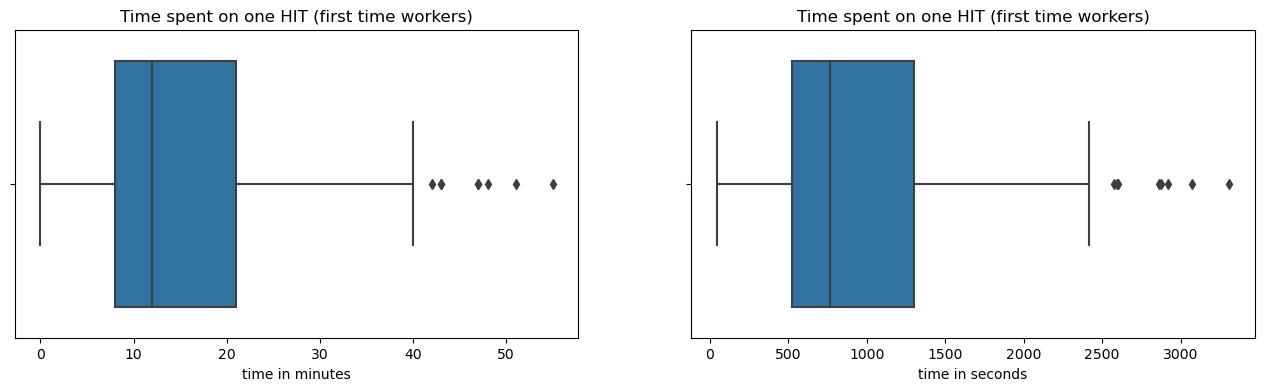

In [137]:
duration_min = []
duration_sec = []
worker_list = []
workers_one_min = []

for index, row in annotations_df.iterrows(): 
    try:
        worker_id = row['worker_id']
    #     if worker_id in worker_list:
    #         Uncomment rows below if we want to know time of non-first time workers
    #         dur_sec, dur_min = calc_annotation_time(row["events"])
    #         duration_sec.append(dur_sec)
    #         duration_min.append(dur_min)
    #         continue
    #     else:
        worker_list.append(worker_id)
        dur_sec, dur_min = calc_annotation_time(row["events"])
        duration_sec.append(dur_sec)
        duration_min.append(dur_min)

        if dur_min <= 1: 
            workers_one_min.append(worker_id)
    except Exception: 
        continue
        
# print boxplot of time duration for task 

fig, ax = plt.subplots(1,2, figsize=(16, 4))
sns.boxplot(x=duration_min, ax = ax[0])
sns.boxplot(x=duration_sec, ax = ax[1])

ax[0].set_title('Time spent on one HIT (first time workers)')
ax[1].set_title('Time spent on one HIT (first time workers)')
ax[0].set(xlabel='time in minutes')
ax[1].set(xlabel='time in seconds')


print(pd.DataFrame(duration_min).describe())


In [138]:
worker_df = annotations_df.query("worker_id == 'A300UPNTHSR0IM'")
# worker_df["hit"].tolist()
worker_df.head()

,_id,batch_id,references,taskSet_id,hit,worker_id,outputs,times,events,feedback,assignment_id
12,3P4ZBJFX321YN4JSXGG1IT6OROIWFT,b7b98cec-1eeb-4b09-8a5d-6d1b2f629243,"[{'db_id': '3NFWQRSHWLC2QITSIBCJWQK0XIKFG5', '...",874cf310-ea93-4937-bf37-9f47508db4f1,"{'HITId': '3P4ZBJFX321YN4JSXGG1IT6OROIWFT', 'H...",A300UPNTHSR0IM,"[{'label_claim': 1, 'label_explanation': 1, 'h...","[61863, 95126, 87103, 32200, 33341, 219007, 27...","[{'timestamp': '2023-05-08T07:28:12.372Z', 'ty...",None,33PPUNGG3G3269R0P054M6AFMTEZRP
14,38LRF35D6SUQFOEUIL0YZWWU3I2U3J,b7b98cec-1eeb-4b09-8a5d-6d1b2f629243,"[{'db_id': '3MJ9GGZYPA4HFX4D8G52GLF8QDAA20', '...",67e48df6-e9e0-4954-aabd-6eaf8c74d716,"{'HITId': '38LRF35D6SUQFOEUIL0YZWWU3I2U3J', 'H...",A300UPNTHSR0IM,"[{'label_claim': 0, 'label_explanation': 0, 'h...","[32332, 99471, 49999, 19255, 127103, 100631, 3...","[{'timestamp': '2023-05-08T07:06:58.863Z', 'ty...",None,3ZGVPD4G61FFMO4STPAZMLBXAE8ZTZ
15,3HUR21WDE1NJCV5DCB4B9XRB61EYXL,b7b98cec-1eeb-4b09-8a5d-6d1b2f629243,"[{'db_id': '3BJKPTD2RJA3YDK7T6BKCYD8QZ3RTJ', '...",b0672caa-3fb9-4308-bb77-a8296829128a,"{'HITId': '3HUR21WDE1NJCV5DCB4B9XRB61EYXL', 'H...",A300UPNTHSR0IM,"[{'label_claim': 1, 'label_explanation': 1, 'h...","[125836, 65941, 144199, 43087, 130615, 31063, ...","[{'timestamp': '2023-05-08T03:53:49.083Z', 'ty...",None,34T446B1C8C1YMWR392HRC874KOC0Y
16,3ATYLI1PS006NXWMPKGCGXLUHT0JO7,b7b98cec-1eeb-4b09-8a5d-6d1b2f629243,"[{'db_id': '3NFWQRSHWLC2QITSIBCJWQK0XIKFG5', '...",a9459353-9b20-48d3-8836-2daf549bffa8,"{'HITId': '3ATYLI1PS006NXWMPKGCGXLUHT0JO7', 'H...",A300UPNTHSR0IM,"[{'label_claim': 1, 'label_explanation': 1, 'h...","[231966, 36509, 211872, 272423, 20767, 166270,...","[{'timestamp': '2023-05-08T03:22:41.942Z', 'ty...",None,33CKWXB73RIHI87BJVHXOL8Q5F3110
17,3S829FDFU9ZGEKAMGFHXWCHAODIXDM,ac30abc5-dd4a-4e17-b529-b0e385337e6a,"[{'db_id': '372AGES0JB3AFUTRYGCH11YE36VRXS', '...",dabca946-58c6-483f-9dee-ddced3e4ba9d,"{'HITId': '3S829FDFU9ZGEKAMGFHXWCHAODIXDM', 'H...",A300UPNTHSR0IM,"[{'label_claim': 0, 'label_explanation': 0, 'h...","[73539, 176670, 120184, 55199, 25278, 100839, ...","[{'timestamp': '2023-05-08T05:56:41.109Z', 'ty...",None,3WSELTNVRB0ELGWKHXU05SKO1TQATY


In [139]:
worker_df["outputs"].tolist()

[[{'label_claim': 1,
   'label_explanation': 1,
   'header': -1,
   'publisher': -1,
   'sub_publisher': -1,
   'claim_rewritten': '3rd Number of alerts scored top in Copyright Alert System.',
   'explanation_rewritten': 'Number 1 Number of alerts has highest peak in Copyright Alert System whereas 3rd number scores third place.'},
  {'label_claim': 0,
   'label_explanation': 1,
   'header': -1,
   'publisher': -1,
   'sub_publisher': -1,
   'claim_rewritten': '',
   'explanation_rewritten': 'Red color which represents the natural gas covers more space in the bar among all other three.'},
  {'label_claim': 0,
   'label_explanation': 1,
   'header': -1,
   'publisher': -1,
   'sub_publisher': -1,
   'claim_rewritten': '',
   'explanation_rewritten': 'the chart clearly shows that coal is not the largest source of electricity generation in Oregon. In fact, it only accounts for 3.2% of the total generation, while hydroelectric power accounts for 56.7%.'},
  {'label_claim': 0,
   'label_expl


### Label distribution

In [140]:
len(output_df)

1697

In [141]:
df = pd.DataFrame({'label': output_df["label"]})
ax = sns.barplot(x=df.label.value_counts().index, y=df.label.value_counts())

s = 0
for p in ax.patches:
    s+= p.get_height()

for p in ax.patches: 
    ax.text(p.get_x() + p.get_width()/2.,
            p.get_height(),
            '{}'.format(int(p.get_height())), 
            fontsize=12,
            color='black',
            ha='center',
            va='bottom')

ax.set_title('Distribution of labels')
ax.set(xlabel='0 = Not_Eng | 1 = Not readable | 2 = Missing parts | 3 = color problem | 4 = others | 5 = Clear ', ylabel='annotations')
# ax.set(xlabel='0 = supported | 1 = refuted ', ylabel='adjusted claims')

plt.show()




KeyError: 'label'

### Print Charts, Claims, Explanations

In [142]:
len(output_df)

1697

In [143]:
output_df.head()

,HIT_id,batch_id,taskSet_id,worker_id,chart_id,chart_img,caption,claim_rewritten,explanation_rewritten,label_claim,label_explanation,events
0,3QGTX7BCIW0AF2V82RNZVL9TJOSZ57,ec997789-b359-467c-8e94-42074979d084,58238466-7d19-45c2-8f54-85a1e0beb9dc,A22IXLFA45IJJ2,30UZJB2PPOA9U9OFHKSQRK4E4D653X,https://chartfc.s3.amazonaws.com/Energyinput_p...,comparison of energy requirement for a study,,The claim is false because the chart compares ...,0,1,"{'timestamp': '2023-04-29T03:46:07.257Z', 'typ..."
1,3QGTX7BCIW0AF2V82RNZVL9TJOSZ57,ec997789-b359-467c-8e94-42074979d084,58238466-7d19-45c2-8f54-85a1e0beb9dc,A22IXLFA45IJJ2,35NNO802B2USA1C46NVZP76PEH7NIB,https://chartfc.s3.amazonaws.com/Olympic_gold_...,Most successful countries in Olympics from 200...,,The chart shows that Germany won the least amo...,0,1,"{'timestamp': '2023-04-29T03:53:48.341Z', 'typ..."
2,3QGTX7BCIW0AF2V82RNZVL9TJOSZ57,ec997789-b359-467c-8e94-42074979d084,58238466-7d19-45c2-8f54-85a1e0beb9dc,A22IXLFA45IJJ2,302U8RURK6ZXW7W45UUI4WWJMNCNVP,https://chartfc.s3.amazonaws.com/How_intereste...,graph for meta report on WMF mexico phone survey,,,0,0,"{'timestamp': '2023-04-29T03:59:32.684Z', 'typ..."
3,3QGTX7BCIW0AF2V82RNZVL9TJOSZ57,ec997789-b359-467c-8e94-42074979d084,58238466-7d19-45c2-8f54-85a1e0beb9dc,A22IXLFA45IJJ2,3LG268AV4F419U2A3BMPDCD7NK1RE4,https://chartfc.s3.amazonaws.com/Occupational_...,This pie chart shows the occupational structur...,The percentage of employed women in Domestic S...,The chart shows that the percentage of employe...,1,1,"{'timestamp': '2023-04-29T04:04:46.383Z', 'typ..."
4,3QGTX7BCIW0AF2V82RNZVL9TJOSZ57,ec997789-b359-467c-8e94-42074979d084,58238466-7d19-45c2-8f54-85a1e0beb9dc,A22IXLFA45IJJ2,34ZTTGSNK4MDH3ECGX5VTP0FJH0HQO,https://chartfc.s3.amazonaws.com/US_male_arres...,Arrests in the United States of males for diso...,The number of males arrested in the United Sta...,The bars showing the number of males arrested ...,1,1,"{'timestamp': '2023-04-29T04:14:09.521Z', 'typ..."


In [144]:
for i, row in output_df.iterrows():
    if i<2500: 
        continue

#     if row['claim_text_support'] == "Females are more likely to suffer from a hip fracture and be hospitalized compared to males for a femoral neck fracture.": 
#         print(row)
#     else: 
#         continue

    # img 
    response = requests.get(row["chart_img"])
    img = Image.open(BytesIO(response.content))
    display(img)        
        
    print(f"caption: {row['caption']}")
    print(f"claim support: {row['claim_text_support']}")
    print(f"expl support: {row['explanation_claim_text_support']}")
    print(f"claim refute: {row['claim_text_refute']}")
    print(f"expl refute: {row['explanation_claim_text_refute']}")

#     if i>100:
#         break
    

In [145]:
output_df["claim_text_refute"].tolist()

KeyError: 'claim_text_refute'

In [146]:
import nltk
allWords = nltk.tokenize.word_tokenize(" ".join(output_df["claim_text_support"].tolist()))
allWordDist = nltk.FreqDist(w.lower() for w in allWords)

stopwords = nltk.corpus.stopwords.words('english')
allWordExceptStopDist = nltk.FreqDist(w.lower() for w in allWords if w not in stopwords)    

KeyError: 'claim_text_support'

In [417]:
# Support
mostCommon= allWordDist.most_common(50) 
mostCommon

[('the', 3260),
 ('.', 2388),
 ('in', 1632),
 ('of', 1575),
 ('is', 612),
 (',', 430),
 ('and', 412),
 ('a', 384),
 ('chart', 373),
 ('to', 368),
 ('than', 360),
 ('for', 328),
 ('highest', 324),
 ('has', 286),
 ('was', 283),
 ('on', 242),
 ('number', 218),
 ('are', 211),
 ('from', 200),
 ('were', 189),
 ('most', 182),
 ('at', 176),
 ('%', 168),
 ('as', 159),
 ('majority', 159),
 ('largest', 157),
 ('more', 150),
 ('shows', 145),
 ('there', 138),
 ('by', 134),
 ('had', 123),
 ('with', 119),
 ('between', 118),
 ('over', 116),
 ("'s", 114),
 ('percentage', 110),
 ('population', 107),
 ('people', 100),
 ('higher', 99),
 ('value', 98),
 ('that', 94),
 ('energy', 93),
 ('time', 90),
 ('1881', 90),
 ('year', 89),
 ('per', 85),
 ('graph', 81),
 ('2011', 81),
 ('wikipedia', 77),
 ('total', 76)]

In [418]:
# Refute
mostCommon= allWordDist.most_common(50)
mostCommon

[('the', 3260),
 ('.', 2388),
 ('in', 1632),
 ('of', 1575),
 ('is', 612),
 (',', 430),
 ('and', 412),
 ('a', 384),
 ('chart', 373),
 ('to', 368),
 ('than', 360),
 ('for', 328),
 ('highest', 324),
 ('has', 286),
 ('was', 283),
 ('on', 242),
 ('number', 218),
 ('are', 211),
 ('from', 200),
 ('were', 189),
 ('most', 182),
 ('at', 176),
 ('%', 168),
 ('as', 159),
 ('majority', 159),
 ('largest', 157),
 ('more', 150),
 ('shows', 145),
 ('there', 138),
 ('by', 134),
 ('had', 123),
 ('with', 119),
 ('between', 118),
 ('over', 116),
 ("'s", 114),
 ('percentage', 110),
 ('population', 107),
 ('people', 100),
 ('higher', 99),
 ('value', 98),
 ('that', 94),
 ('energy', 93),
 ('time', 90),
 ('1881', 90),
 ('year', 89),
 ('per', 85),
 ('graph', 81),
 ('2011', 81),
 ('wikipedia', 77),
 ('total', 76)]

In [419]:
# Support
mostCommon= allWordExceptStopDist.most_common(50)
mostCommon

[('.', 2388),
 ('the', 1069),
 (',', 430),
 ('chart', 373),
 ('highest', 324),
 ('number', 218),
 ('in', 172),
 ('%', 168),
 ('majority', 159),
 ('largest', 157),
 ('shows', 145),
 ("'s", 114),
 ('there', 110),
 ('percentage', 110),
 ('population', 107),
 ('people', 100),
 ('higher', 99),
 ('value', 98),
 ('energy', 93),
 ('time', 90),
 ('1881', 90),
 ('year', 89),
 ('per', 85),
 ('graph', 81),
 ('2011', 81),
 ('wikipedia', 77),
 ('total', 76),
 ('less', 75),
 ('electricity', 74),
 ('increased', 74),
 ('share', 73),
 ('source', 69),
 ('age', 69),
 ('(', 64),
 (')', 64),
 ('united', 63),
 ('states', 62),
 ('wikimedia', 60),
 ('years', 60),
 ('2014', 57),
 ('rate', 56),
 ('2008', 55),
 ('2010', 55),
 ('agriculture', 55),
 ('males', 54),
 ('generation', 54),
 ('2018', 54),
 ('average', 53),
 ('top', 52),
 ('group', 51)]

In [420]:
# REfute 

mostCommon= allWordExceptStopDist.most_common(50)
mostCommon

[('.', 2388),
 ('the', 1069),
 (',', 430),
 ('chart', 373),
 ('highest', 324),
 ('number', 218),
 ('in', 172),
 ('%', 168),
 ('majority', 159),
 ('largest', 157),
 ('shows', 145),
 ("'s", 114),
 ('there', 110),
 ('percentage', 110),
 ('population', 107),
 ('people', 100),
 ('higher', 99),
 ('value', 98),
 ('energy', 93),
 ('time', 90),
 ('1881', 90),
 ('year', 89),
 ('per', 85),
 ('graph', 81),
 ('2011', 81),
 ('wikipedia', 77),
 ('total', 76),
 ('less', 75),
 ('electricity', 74),
 ('increased', 74),
 ('share', 73),
 ('source', 69),
 ('age', 69),
 ('(', 64),
 (')', 64),
 ('united', 63),
 ('states', 62),
 ('wikimedia', 60),
 ('years', 60),
 ('2014', 57),
 ('rate', 56),
 ('2008', 55),
 ('2010', 55),
 ('agriculture', 55),
 ('males', 54),
 ('generation', 54),
 ('2018', 54),
 ('average', 53),
 ('top', 52),
 ('group', 51)]

### [TABLE ANNOTATION TASK] Majority voting 

In [147]:
def majority(votes):
    votes = [v for v in votes if v != -1]
    if collections.Counter(votes).most_common(1)[0][1] == 1: 
        return -1
    else:
        return collections.Counter(votes).most_common(1)[0][0]


In [148]:
output_df.head()

,HIT_id,batch_id,taskSet_id,worker_id,chart_id,chart_img,caption,claim_rewritten,explanation_rewritten,label_claim,label_explanation,events
0,3QGTX7BCIW0AF2V82RNZVL9TJOSZ57,ec997789-b359-467c-8e94-42074979d084,58238466-7d19-45c2-8f54-85a1e0beb9dc,A22IXLFA45IJJ2,30UZJB2PPOA9U9OFHKSQRK4E4D653X,https://chartfc.s3.amazonaws.com/Energyinput_p...,comparison of energy requirement for a study,,The claim is false because the chart compares ...,0,1,"{'timestamp': '2023-04-29T03:46:07.257Z', 'typ..."
1,3QGTX7BCIW0AF2V82RNZVL9TJOSZ57,ec997789-b359-467c-8e94-42074979d084,58238466-7d19-45c2-8f54-85a1e0beb9dc,A22IXLFA45IJJ2,35NNO802B2USA1C46NVZP76PEH7NIB,https://chartfc.s3.amazonaws.com/Olympic_gold_...,Most successful countries in Olympics from 200...,,The chart shows that Germany won the least amo...,0,1,"{'timestamp': '2023-04-29T03:53:48.341Z', 'typ..."
2,3QGTX7BCIW0AF2V82RNZVL9TJOSZ57,ec997789-b359-467c-8e94-42074979d084,58238466-7d19-45c2-8f54-85a1e0beb9dc,A22IXLFA45IJJ2,302U8RURK6ZXW7W45UUI4WWJMNCNVP,https://chartfc.s3.amazonaws.com/How_intereste...,graph for meta report on WMF mexico phone survey,,,0,0,"{'timestamp': '2023-04-29T03:59:32.684Z', 'typ..."
3,3QGTX7BCIW0AF2V82RNZVL9TJOSZ57,ec997789-b359-467c-8e94-42074979d084,58238466-7d19-45c2-8f54-85a1e0beb9dc,A22IXLFA45IJJ2,3LG268AV4F419U2A3BMPDCD7NK1RE4,https://chartfc.s3.amazonaws.com/Occupational_...,This pie chart shows the occupational structur...,The percentage of employed women in Domestic S...,The chart shows that the percentage of employe...,1,1,"{'timestamp': '2023-04-29T04:04:46.383Z', 'typ..."
4,3QGTX7BCIW0AF2V82RNZVL9TJOSZ57,ec997789-b359-467c-8e94-42074979d084,58238466-7d19-45c2-8f54-85a1e0beb9dc,A22IXLFA45IJJ2,34ZTTGSNK4MDH3ECGX5VTP0FJH0HQO,https://chartfc.s3.amazonaws.com/US_male_arres...,Arrests in the United States of males for diso...,The number of males arrested in the United Sta...,The bars showing the number of males arrested ...,1,1,"{'timestamp': '2023-04-29T04:14:09.521Z', 'typ..."


In [149]:
# pre_label_df = output_df[['HIT_id', 'chart_id','chart_img','label','header']].copy()
# pre_label_df['label'] = pre_label_df['label'].apply(lambda x : [x])
# pre_label_df['header'] = pre_label_df['header'].apply(lambda x : [x] if x==-1 else x)
# pre_label_df.head()

pre_label_df = output_df[['HIT_id', 'chart_id','chart_img','label_claim']].copy()
pre_label_df['label'] = pre_label_df['label_claim'].apply(lambda x : [x])
pre_label_df.head()


,HIT_id,chart_id,chart_img,label_claim,label
0,3QGTX7BCIW0AF2V82RNZVL9TJOSZ57,30UZJB2PPOA9U9OFHKSQRK4E4D653X,https://chartfc.s3.amazonaws.com/Energyinput_p...,0,[0]
1,3QGTX7BCIW0AF2V82RNZVL9TJOSZ57,35NNO802B2USA1C46NVZP76PEH7NIB,https://chartfc.s3.amazonaws.com/Olympic_gold_...,0,[0]
2,3QGTX7BCIW0AF2V82RNZVL9TJOSZ57,302U8RURK6ZXW7W45UUI4WWJMNCNVP,https://chartfc.s3.amazonaws.com/How_intereste...,0,[0]
3,3QGTX7BCIW0AF2V82RNZVL9TJOSZ57,3LG268AV4F419U2A3BMPDCD7NK1RE4,https://chartfc.s3.amazonaws.com/Occupational_...,1,[1]
4,3QGTX7BCIW0AF2V82RNZVL9TJOSZ57,34ZTTGSNK4MDH3ECGX5VTP0FJH0HQO,https://chartfc.s3.amazonaws.com/US_male_arres...,1,[1]


In [150]:
label_df = pre_label_df.groupby(['chart_id', 'HIT_id']).agg({'label': "sum"}) 
# for checking the quality of work run below to look at chart images
#label_df = pre_label_df.groupby(['chart_img', 'HIT_id']).agg({'label': "sum"}) 
label_df.head()


label
chart_id                       HIT_id                                   
302U8RURK6ZXW7W45UUI4WWJMNCNVP 3IZPORCT2M7DT4TCTCUVYFAKFO3HRW  [0, 0, 0]
                               3PGQRAZX19IBGEJEI1YOAPAJROTSYS        [0]
                               3QGTX7BCIW0AF2V82RNZVL9TJOSZ57        [0]
307L9TDWK5QDKYULLKOCL140V0PN3S 389A2A305VGYC2YXD7XF3SCHT8T0C6  [0, 0, 0]
307L9TDWK5QDKYULLKOCL140VDK3NT 3NFWQRSHWLC2QITSIBCJWQK0X0FFG0  [0, 0, 0]

In [153]:
# label_df = pre_label_df.groupby(['claim_id', 'HIT_id']).agg('sum') 
# label_df = pre_label_df.groupby(['majority']).agg('sum')

label_df = label_df.dropna()

print(f"Length before filtering for charts with three assignments: {len(label_df)}")
label_df = pd.DataFrame([row for index, row in label_df.iterrows() if len(row["label"])==3])
label_df['majority'] = label_df['label'].apply(majority)

label_df = label_df.reset_index()

print(f"Length after filtering for charts with three assignments: {len(label_df)}")
label_df.head(5)


Length before filtering for charts with three assignments: 1046
Length after filtering for charts with three assignments: 187


,level_0,level_1,label,majority
0,302U8RURK6ZXW7W45UUI4WWJMNCNVP,3IZPORCT2M7DT4TCTCUVYFAKFO3HRW,"[0, 0, 0]",0
1,307L9TDWK5QDKYULLKOCL140V0PN3S,389A2A305VGYC2YXD7XF3SCHT8T0C6,"[0, 0, 0]",0
2,307L9TDWK5QDKYULLKOCL140VDK3NT,3NFWQRSHWLC2QITSIBCJWQK0X0FFG0,"[0, 0, 0]",0
3,30QQTY5GNRI8G7FHKX3OCD8A8X1U7R,30EV7DWJU2T6TGLHBOVL9KER9YO6YA,"[1, 1, 1]",1
4,30QQTY5GNRI8G7FHKX3OCD8A8X1U7R,344M16OZLPDGUWAIA4584S8XMCVNE9,"[0, 0, 0]",0


In [154]:
pd.set_option('display.max_rows', 140)
label_df

,level_0,level_1,label,majority
0,302U8RURK6ZXW7W45UUI4WWJMNCNVP,3IZPORCT2M7DT4TCTCUVYFAKFO3HRW,"[0, 0, 0]",0
1,307L9TDWK5QDKYULLKOCL140V0PN3S,389A2A305VGYC2YXD7XF3SCHT8T0C6,"[0, 0, 0]",0
2,307L9TDWK5QDKYULLKOCL140VDK3NT,3NFWQRSHWLC2QITSIBCJWQK0X0FFG0,"[0, 0, 0]",0
3,30QQTY5GNRI8G7FHKX3OCD8A8X1U7R,30EV7DWJU2T6TGLHBOVL9KER9YO6YA,"[1, 1, 1]",1
4,30QQTY5GNRI8G7FHKX3OCD8A8X1U7R,344M16OZLPDGUWAIA4584S8XMCVNE9,"[0, 0, 0]",0
...,...,...,...,...
182,3XQ4XW3OEGALFTQ7PGRT1L9ECZDS26,3OJX0UFJ165CUQ3AZU18Q9ZG3AZ9U2,"[0, 1, 0]",0
183,3YO4AH2FQKI2638GIPYANX1YXWQ0QP,36U4VBVNRVBIYQZWTB1UHUZA9WSURX,"[0, 0, 0]",0
184,3YO4AH2FQKI2638GIPYANX1YXWQ0QP,3ZXV7Q5FKIMP96DNGPG06ZZLZ8NFCQ,"[1, 0, 0]",0
185,3YOAVL4CB7FSJJR8OM4PQT3FJCQZ4Z,36U4VBVNRVBIYQZWTB1UHUZA9WSURX,"[0, 0, 0]",0


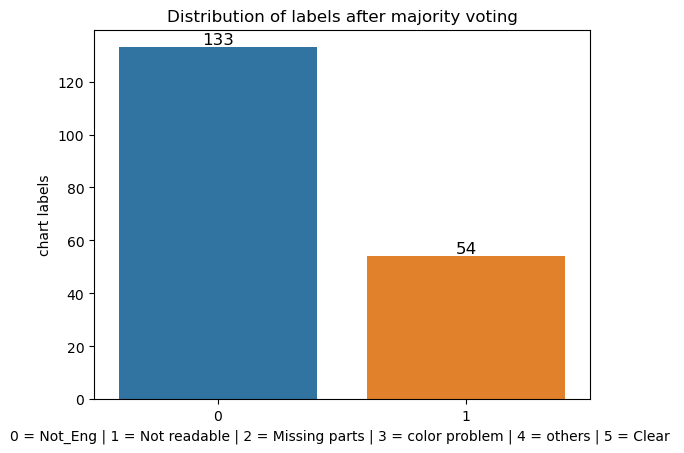

In [155]:
df = pd.DataFrame({'label': label_df["majority"]})
ax = sns.barplot(x=df.label.value_counts().index, y=df.label.value_counts())

s = 0
for p in ax.patches:
    s+= p.get_height()

for p in ax.patches: 
    ax.text(p.get_x() + p.get_width()/2.,
            p.get_height(),
            '{}'.format(int(p.get_height())), 
            fontsize=12,
            color='black',
            ha='center',
            va='bottom')

ax.set_title('Distribution of labels after majority voting')
ax.set(xlabel='0 = Not_Eng | 1 = Not readable | 2 = Missing parts | 3 = color problem | 4 = others | 5 = Clear ', ylabel='chart labels')
plt.show()


In [156]:
print(len(df))

1711/len(df)

187


9.149732620320856

In [157]:
label_df.head()

,level_0,level_1,label,majority
0,302U8RURK6ZXW7W45UUI4WWJMNCNVP,3IZPORCT2M7DT4TCTCUVYFAKFO3HRW,"[0, 0, 0]",0
1,307L9TDWK5QDKYULLKOCL140V0PN3S,389A2A305VGYC2YXD7XF3SCHT8T0C6,"[0, 0, 0]",0
2,307L9TDWK5QDKYULLKOCL140VDK3NT,3NFWQRSHWLC2QITSIBCJWQK0X0FFG0,"[0, 0, 0]",0
3,30QQTY5GNRI8G7FHKX3OCD8A8X1U7R,30EV7DWJU2T6TGLHBOVL9KER9YO6YA,"[1, 1, 1]",1
4,30QQTY5GNRI8G7FHKX3OCD8A8X1U7R,344M16OZLPDGUWAIA4584S8XMCVNE9,"[0, 0, 0]",0


### Iterate over MongoDB file and update majority vote 

In [298]:
for i, row in label_df.iterrows():
#     print(f"{row['level_0']}")
    db.chart_filtering.find_one_and_update({"_id": ObjectId(row["level_0"])}, {"$set": {"chart_filter_majority": row["majority"]}})
    

### Update majority voting label in final_dataset in DB (=> needed for claim generation)

In [ ]:
final_ds_col = db.final_dataset

cursor =  final_ds_col.find({})
df = pd.DataFrame(list(cursor)) 
print(f"Length of test set: {len(df)}")
df.head(3)


In [ ]:
# how many (claim, relevant_table) pairs we have in final_ds

temp = [len(x) for x in df["table_relevant"] if x and type(x) == list]
sum(temp) # total


In [ ]:
# Extract from output_df all entries with majority voting "2" (="relevant")

x = []
for claim_id, hit_id in list(label_df[label_df["majority"]==2]["index"]):
    x.append(output_df[(output_df["chart_id"]==claim_id) & (output_df["HIT_id"]==hit_id)].iloc[0,:])

output_df_majority = pd.DataFrame(x)
print(len(output_df_majority))
output_df_majority.head(1)


In [ ]:
# update final_dataset collection in MongoDB 
# Add tables to column "table_relevant" in final_dataset

counter = 0
for index, row in df.iterrows(): # iterate over final_dataset
    _id = str(row["_id"])
    
    for i, r in output_df_majority.iterrows(): # iterate over claims with relevant tables (accord. to majority voting)
        annotated_table = r["table"]
        change = 0
        
        if _id != r["claim_id"]:
            continue 
            
        temp_list = row["table_relevant"] if type(row["table_relevant"]) == list else []
        relevant_tables = []
        for relevant_t in temp_list:
            if "_id" in relevant_t:
                relevant_t["id"] = relevant_t["_id"]
                del relevant_t["_id"]
                
            relevant_tables.append(relevant_t)
        
        if "id" in annotated_table: 
            if annotated_table["id"] not in [t["id"] for t in relevant_tables]:
                relevant_tables.append(annotated_table)
                change = 1
                
        elif "_id" in annotated_table: 
            if annotated_table["_id"] not in [t["id"] for t in relevant_tables]:
                annotated_table["id"] = annotated_table["_id"].copy()
                del annotated_table["_id"]
                relevant_tables.append(annotated_table)
                change = 1

        else: # find matching _id for annotated_table first
            for table in row["tables"]: 

                if table["rows_list"] == annotated_table["rows_list"]:
                    not_added_before = False
                    for tab in relevant_tables:
                        if annotated_table["rows_list"] == tab["rows_list"]: 
                            not_added_before = True

                    if not_added_before:
                        annotated_table["id"] = table["id"]
                        relevant_tables.append(annotated_table)
                        change = 1

        if change:
            counter += 1
            final_ds_col.update_one({'_id': row["_id"]},
                                    {'$set': {'table_relevant': relevant_tables}})

counter
        

### Update majority voting in claim_generation dataset (=> after adjusted claim annotation)

In [ ]:
claim_col = db.claim_generation
cursor =  claim_col.find({})
df = pd.DataFrame(list(cursor)) 
print(f"Length of data set: {len(df)}")
df.head(3)


In [ ]:
df['_id_str'] = df['_id'].astype('str')
no_entries = []

for index, row in label_df.iterrows(): 
    _id = row["index"][0]
    row_id = df.loc[df['_id_str'] == _id]["_id"]
    
    if len(row_id.values) == 0:
        no_entries.append(row["index"])
        continue
    
#         Uncomment to update claim_generation collection in MongoDB
#     claim_col.update_one({'_id': row_id.values[0]}, 
#                          {
#                              '$set': {'majority_label': str(row["majority"]), 
#                                       'majority_header': row["header"]}
#                          })

print(len(no_entries))


In [ ]:
no_entries[0]

In [ ]:
output_df.head(1)

In [ ]:
# todo enter for ids in "no_entries" list the corrsponding claim table pair to the collection "claim_generation" in MongoDB

for claim_id, hit_id in no_entries: 
    row = output_df.loc[(output_df['claim_id'] == claim_id) && (output_df['HIT_id'] == hit_id)]
    


### Header rationales 

In [ ]:

label_list = [len(entry) for entry in output_df["header"] if (entry!=-1 and entry!=[])]
df = pd.DataFrame({'label': label_list})
# sns.histplot(data=label_list)

ax = sns.barplot(x=df.label.value_counts().index, y=df.label.value_counts())

s = 0
for p in ax.patches:
    s+= p.get_height()

for p in ax.patches: 
    ax.text(p.get_x() + p.get_width()/2.,
            p.get_height(),
            '{}'.format(int(p.get_height())), 
            fontsize=11,
            color='black',
            ha='center',
            va='bottom')
    
ax.set_title('Number of column rationales selected')
ax.set(ylabel='count')

plt.show()


In [ ]:
workers = []
for index, row in annotations_df.iterrows():
    for output in row["outputs"]: 
        if output['label']==0:
            workers.append(row["worker_id"])
            
print("Workers + count of claims they selected header rationales for:")
Counter(workers).most_common()

### [CLAIM GENERATION TASK] Adjusted Claims

In [ ]:
add_adjusted_claims = True
claim_generation_col = db.claim_generation
counter = 0

if add_adjusted_claims:
    for index, row in output_df.iterrows(): 
        if list(claim_generation_col.find({'claim': row["adjusted_claim"]})) == []:
            counter += 1
            claim_generation_col.insert_one({"_id": uuid.uuid4(), 
                                             "claim": row["adjusted_claim"],
                                             "table": row["table"],
                                             "label": row["label"],
                                             "initial_claim_id": row["claim_id"],
                                             "initial_claim": row["claim"]})
print(counter)


### Feedback

In [ ]:
[entry for entry in annotations_df["feedback"] if entry!=None]

### Some further analysis

In [ ]:
# label_list = [str(entry["label"]) for annotation in annotations_df["outputs"] for entry in annotation]
df = pd.DataFrame({'label': output_df["label"]})


In [ ]:
output_df

In [ ]:
related_pairs = {}
for index, row in output_df.iterrows():
    if row["label"] == 2: 
        related_pairs[row["claim"]] = [row["worker_id"]]

len(related_pairs)


In [ ]:
list(related_pairs.keys())

In [ ]:
db_client.close()

#### Add output_df_majority to final dataset to balance NEI class

In [ ]:
import copy
import jsonlines

from sklearn.model_selection import train_test_split


In [ ]:
output_df_majority.head(3)

In [ ]:
# templates used for dataset creation

entry_template = {
    "_id": "", 
    "claim": "", 
    "label": "", 
    "header_rationale": "", 
    "table": "",
    "initial_claim": ""
}

table_template = {
    'website': "",
    'website_title': "",
    'caption': "",
    'header_horizontal': "",
    'header_vertical': "",
    'rows': "",
    'html_code': ""
}


In [ ]:
# Load dataset

dataset = []
with jsonlines.open('data/dataset.jsonl') as reader:
    for line in reader: 
        dataset.append(line)

len(dataset)

In [ ]:
list_of_claims = list(pd.DataFrame(dataset)["claim"])
len(list_of_claims)

In [ ]:
result_dict=[]

#removing the duplicate entry
for i in range(len(Langlist)): 
    if Langlist[i] not in Langlist[i + 1:]: 
        result_dict.append(Langlist[i]) 


In [ ]:
# create dataset using templates

for index, row in output_df_majority.iterrows():
    if row["claim"] in list_of_claims: 
        continue
    else: 
        list_of_claims.append(row["claim"])
    
    table = copy.deepcopy(table_template)
    table["website"] = row["table"]["url"]
    table["website_title"] = row["table"]["title"]
    table["caption"] = row["table"]["caption"]
    table["header_horizontal"] = row["table"]["header_horizontal"]
    table["header_vertical"] = row["table"]["header_vertical"]
    table["rows"] = row["table"]["rows_list"]
    table["html_code"] = row["table"]["html_table"]
    
    entry = copy.deepcopy(entry_template)
    entry["table"] = table
    entry["_id"] = str(row["claim_id"])
    entry["claim"] = row["claim"]
    entry["label"] = "NOT ENOUGH INFO"
    entry["header_rationale"] = row["header"]
    entry["initial_claim"] = row["claim"]
    
    dataset.append(entry)

print(len(dataset))


In [ ]:
trainset, testset = train_test_split(dataset.copy(), test_size=0.2)  
testset, evalset = train_test_split(testset.copy(), test_size=0.5)  

print(len(trainset))
print(len(evalset))
print(len(testset))


In [ ]:
# Load data

# save dataset in jsonl file 

# with jsonlines.open('data/dataset_balanced.jsonl', mode='w') as writer:
#     writer.write_all(dataset)

# with jsonlines.open('data/trainset.jsonl', mode='w') as writer:
#     writer.write_all(trainset)

# with jsonlines.open('data/evalset.jsonl', mode='w') as writer:
#     writer.write_all(evalset)

# with jsonlines.open('data/testset.jsonl', mode='w') as writer:
#     writer.write_all(testset)
